# Incident Management with Predictive Analytics and Forecasting

### Importing libraires

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from statsmodels.tsa.arima.model import ARIMA

### Importing warnings to ignore the warning

In [171]:
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [173]:
# Importing the csv file
df = pd.read_csv('incident_dataset.csv')

### Data Exploration

In [175]:
# Display the first few rows of the dataset
df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [176]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [177]:
# Summary statistics
df.describe()

,reassignment_count,reopen_count,sys_mod_count
count,141712.000000,141712.000000,141712.000000
mean,1.104197,0.021918,5.080946
std,1.734673,0.207302,7.680652
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


In [178]:
# Check for missing values
df.isnull().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

## Data Preprocess

### Most of the columns have (?) in place of unknown values. Replacing them by Unknown

In [181]:
df.replace(['?'],'Unknown',inplace=True)

### Handling Categorical Data

In [183]:
label_encoders = {}
categorical_features = ['impact', 'urgency', 'category', 'subcategory', 'assignment_group']

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

### Standardization

In [185]:
# Standardize numerical features
features = ['reassignment_count', 'reopen_count', 'sys_mod_count']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Predicting Priority of Tickets

### Priority Distribution

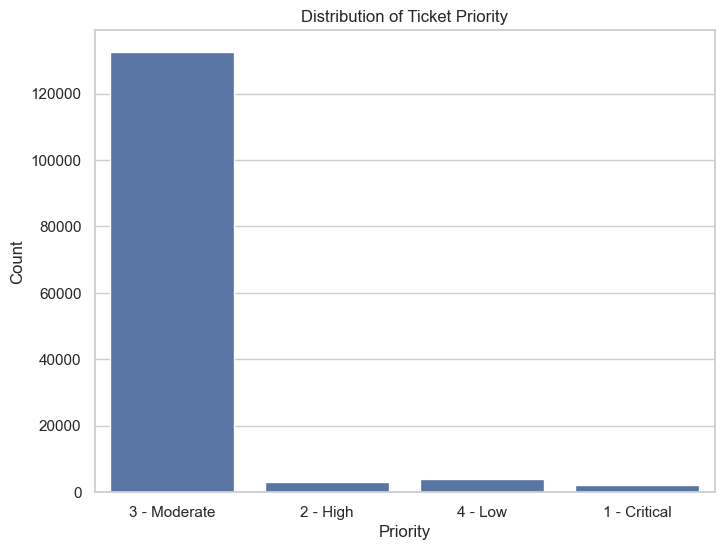

In [188]:
# Plot the distribution of 'priority'
plt.figure(figsize=(8,6))
sns.countplot(x='priority', data=df)
plt.title('Distribution of Ticket Priority')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()

### Preparing Data

In [190]:
# Define features and target
X = df[['impact', 'urgency', 'category', 'subcategory', 'assignment_group']]
y = df['priority']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training Models

In [192]:
# Support Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

## Evaluating Models

### Classification report and Confusion matrix

In [195]:
# Function to print classification report and confusion matrix
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

evaluate_model(y_test, y_pred_svc, 'SVM')
evaluate_model(y_test, y_pred_dt, 'Decision Tree')
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_knn, 'K-Nearest Neighbors')

Model: SVM
              precision    recall  f1-score   support

1 - Critical       0.00      0.00      0.00       692
    2 - High       0.00      0.00      0.00       903
3 - Moderate       0.93      1.00      0.97     39730
     4 - Low       0.00      0.00      0.00      1189

    accuracy                           0.93     42514
   macro avg       0.23      0.25      0.24     42514
weighted avg       0.87      0.93      0.90     42514

[[    0     0   692     0]
 [    0     0   903     0]
 [    0     0 39730     0]
 [    0     0  1189     0]]
Model: Decision Tree
              precision    recall  f1-score   support

1 - Critical       1.00      1.00      1.00       692
    2 - High       1.00      1.00      1.00       903
3 - Moderate       1.00      1.00      1.00     39730
     4 - Low       1.00      1.00      1.00      1189

    accuracy                           1.00     42514
   macro avg       1.00      1.00      1.00     42514
weighted avg       1.00      1.00      1.00 

## Comparison graphs for accuracy, precision, recall, and F1 score

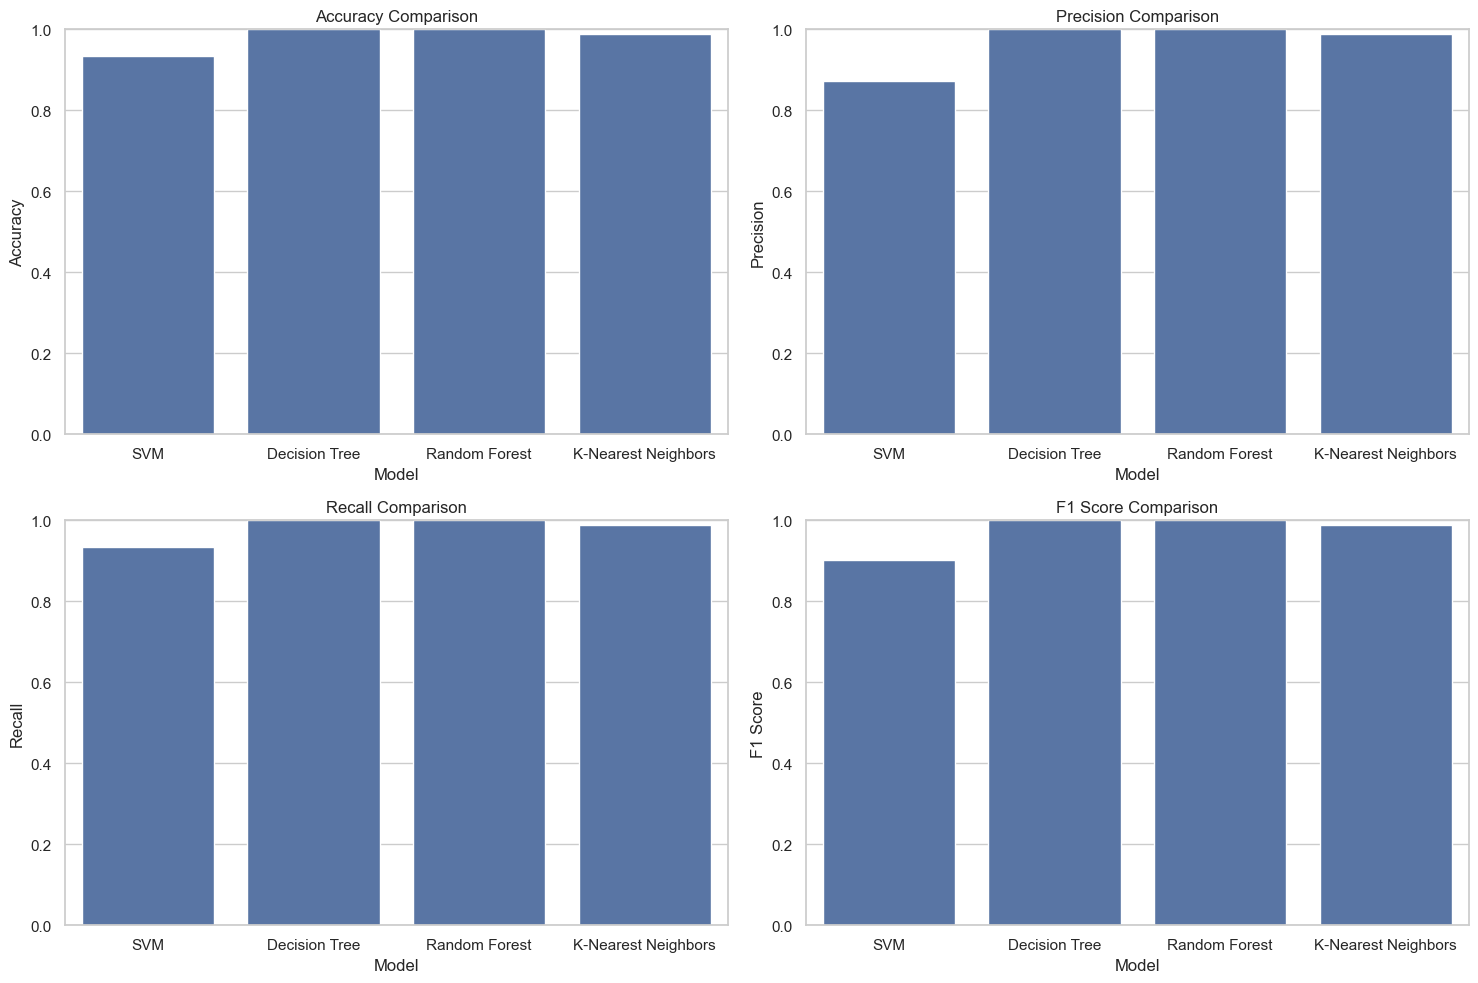

In [197]:
# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Function to calculate and store metrics
def calculate_metrics(y_true, y_pred, model_name):
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_true, y_pred, average='weighted'))

# Evaluate models and store metrics
calculate_metrics(y_test, y_pred_svc, 'SVM')
calculate_metrics(y_test, y_pred_dt, 'Decision Tree')
calculate_metrics(y_test, y_pred_rf, 'Random Forest')
calculate_metrics(y_test, y_pred_knn, 'K-Nearest Neighbors')

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

# Plotting the metrics
sns.set(style="whitegrid")

# Create a bar plot for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=metrics_df, ax=axes[0, 0])
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylim(0, 1)

# Precision
sns.barplot(x='Model', y='Precision', data=metrics_df, ax=axes[0, 1])
axes[0, 1].set_title('Precision Comparison')
axes[0, 1].set_ylim(0, 1)

# Recall
sns.barplot(x='Model', y='Recall', data=metrics_df, ax=axes[1, 0])
axes[1, 0].set_title('Recall Comparison')
axes[1, 0].set_ylim(0, 1)

# F1 Score
sns.barplot(x='Model', y='F1 Score', data=metrics_df, ax=axes[1, 1])
axes[1, 1].set_title('F1 Score Comparison')
axes[1, 1].set_ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()

# Forecasting Incident Volume

### Time Series Preparation

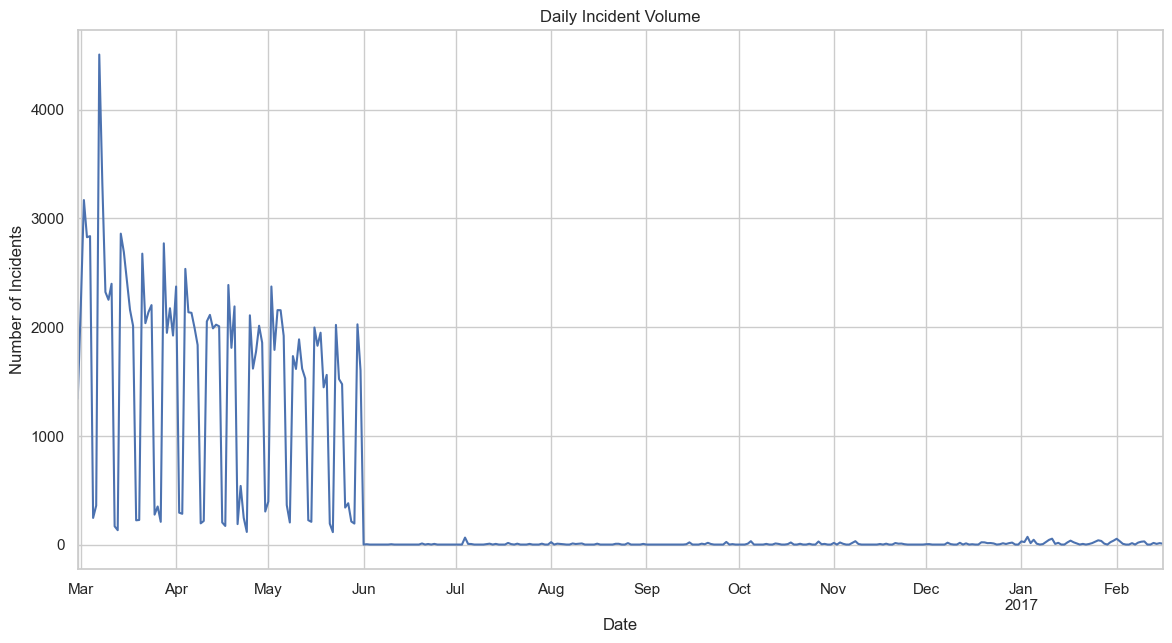

In [200]:
#'opened_at' is datetime and set as index
df['opened_at'] = pd.to_datetime(df['opened_at'])
df.set_index('opened_at', inplace=True)

# Aggregate incidents by day
daily_incidents = df.resample('D').size()

# Plot the time series
plt.figure(figsize=(14,7))
daily_incidents.plot()
plt.title('Daily Incident Volume')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

### Stationarity Check

ARIMA requires the time series to be stationary. We'll use the Augmented Dickey-Fuller test and visualize rolling statistics.

In [202]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    result = adfuller(timeseries)
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (H0), reject the null hypothesis. The data is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

# Perform ADF test
adf_test(daily_incidents)


Results of Augmented Dickey-Fuller Test:
ADF Test Statistic: -2.728808414541296
p-value: 0.06918443946340355
# Lags Used: 17
Number of Observations Used: 336
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


### If the series is non-stationary, we'll apply differencing.

In [204]:
# Differencing to make the series stationary
daily_incidents_diff = daily_incidents.diff().dropna()

# Perform ADF test again
adf_test(daily_incidents_diff)


Results of Augmented Dickey-Fuller Test:
ADF Test Statistic: -4.581996914848867
p-value: 0.00013940714275133154
# Lags Used: 16
Number of Observations Used: 336
Strong evidence against the null hypothesis (H0), reject the null hypothesis. The data is stationary.


# Autocorrelation Function and Partial Autocorrelation Function

These plots help in determining the parameters for the ARIMA model.

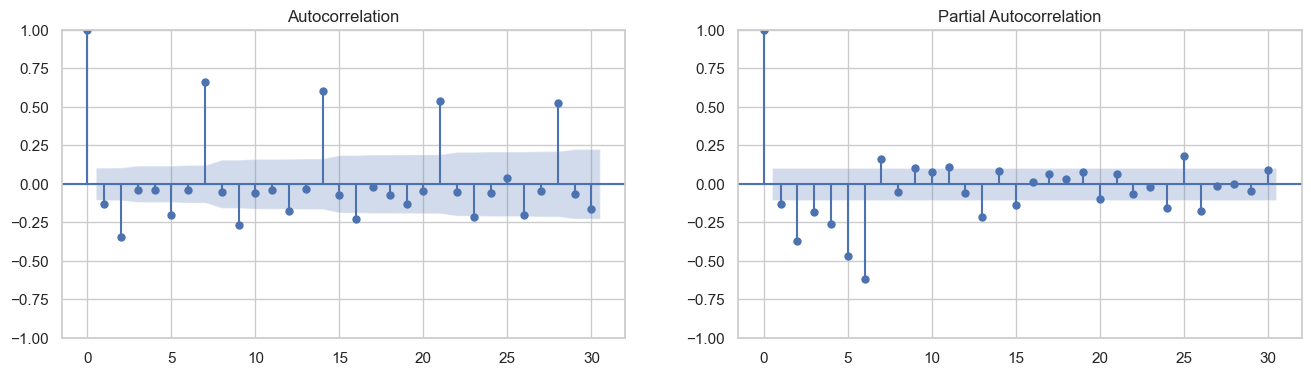

In [206]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(daily_incidents_diff, ax=axes[0], lags=30)
plot_pacf(daily_incidents_diff, ax=axes[1], lags=30)
plt.show()

# ARIMA Model Training
Based on ACF and PACF plots, choose appropriate p, d, and q parameters. 

In [208]:
# Initialize the ARIMA model
model = ARIMA(daily_incidents, order=(5, 1, 0))

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast future incidents
forecast = model_fit.forecast(steps=30)  # Forecasting the next 30 days
print(forecast)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  354
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2660.009
Date:                Sat, 31 Aug 2024   AIC                           5332.017
Time:                        19:24:10   BIC                           5355.216
Sample:                    02-29-2016   HQIC                          5341.248
                         - 02-16-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4297      0.025    -17.128      0.000      -0.479      -0.381
ar.L2         -0.6379      0.022    -29.398      0.000      -0.680      -0.595
ar.L3         -0.5160      0.027    -18.901      0.0

# Forecasting and Visualization
Forecast the next 30 days of incident volumes.

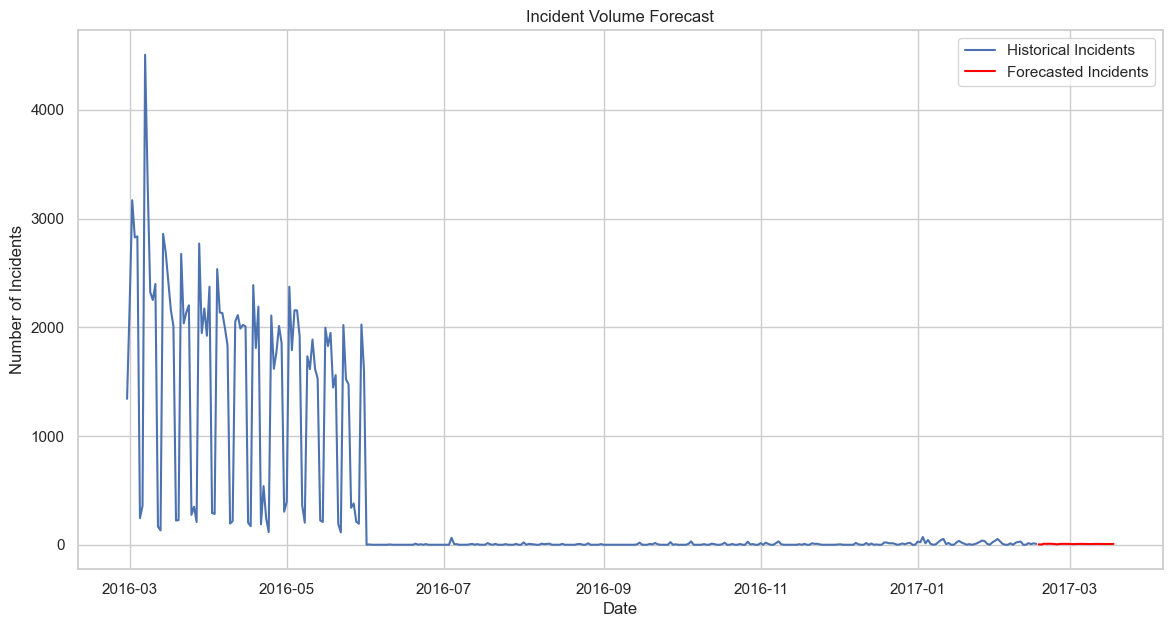

In [210]:
# Forecasting the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
last_date = daily_incidents.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecasted_Incidents': forecast}, index=forecast_dates)

# Plot historical data and forecast
plt.figure(figsize=(14,7))
plt.plot(daily_incidents, label='Historical Incidents')
plt.plot(forecast_df, label='Forecasted Incidents', color='red')
plt.title('Incident Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()
